# Customer Segmentation

We are using a credit card providers database to develop customer segments for targeted business strategies categorizing customers into distinct groups and providing detailed analyses of each segment's defining characteristics and differentiating features.

We will proceed through these key phases to fulfill our project objectives:

* Perform comprehensive dataset exploration and analysis
* Transform and preprocess data for optimal modeling
* Determine the ideal number of customer segments
* Execute the clustering algorithm
* Analyze and present segment insights and distinguishing factors

In [31]:
# Import required libraries

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For statistical visualizations
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.cluster import KMeans  # For K-means clustering

# Random seed for k-means
np.random.seed(42)

In [32]:
# Configure visualization settings
sns.set_style('whitegrid')  # Set seaborn style to whitegrid

# Exploratory Data Analysis

After reading the data into pandas, it's time to explore it. Let's investigate the size of the dataset, what columns it contains, the type of values in each column, and also check on missing values.

In [33]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [34]:
customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CDAP25/Session 4/customer_segmentation.csv')

customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [35]:
customers.shape

(10127, 14)

In [37]:
colors = ['#1A1F71', '#FFC72C', '#EB001B', '#F79E1B', '#000000']

In [38]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are 10127 rows and 14 columns in the dataset including a unique identifier for each client, which is not going to be needed for the segmentation.

Of the 13 columns left, there are 8 columns containing integers, 2 containing floats, and 3 columns containing strings, which means we have 3 categorical columns to deal with.

In [39]:
# let's review categorical variables
for col in ['gender', 'education_level', 'marital_status']:
    print(col)
    print(customers[col].value_counts(), end='\n\n')

gender
gender
F    5358
M    4769
Name: count, dtype: int64

education_level
education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



**Here** We can see how many unique categories are there in each categorical variable and how many datapoints per category.

As we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables.

But we can see the correlation between the numeric variables and their distributions.

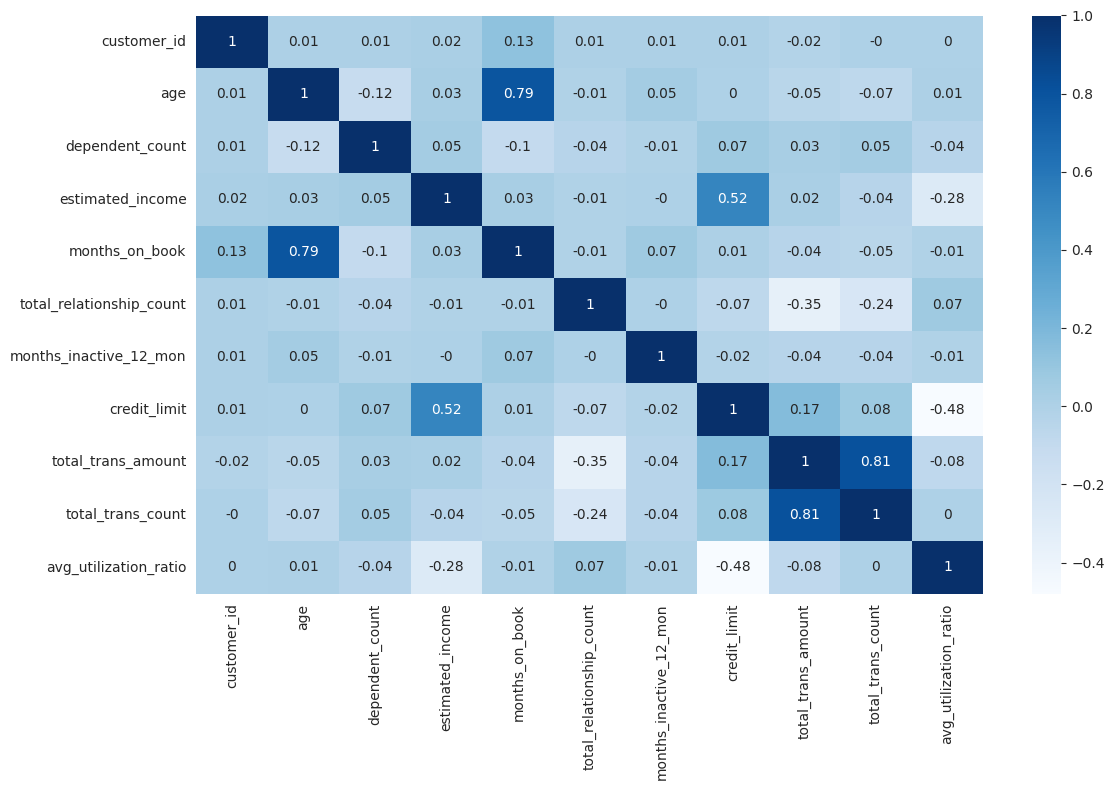

In [42]:
# Correlation heatmap for unsupervised clustering analysis

fig, ax = plt.subplots(figsize=(12,8))
numeric_cols = customers.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(round(customers[numeric_cols].corr(), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()  # Adjust spacing between plot elements
plt.show()

Most of the variables present weak correlations between each other, but there are some we can highlight:

* Age is strongly correlated with how long the person has been a customer (months_on_book);
* Credit limit is positively correlated with the estimated income and negatively correlated with the average utilization ratio;
* The total number of transactions (total_trans_count) is strongly correlated with the total amount transitioned (total_trans_amount).


<ipython-input-43-ce48a478dc35>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  customers.drop('customer_id', axis=1).hist(ax=ax)  # Plot histograms, exclude ID


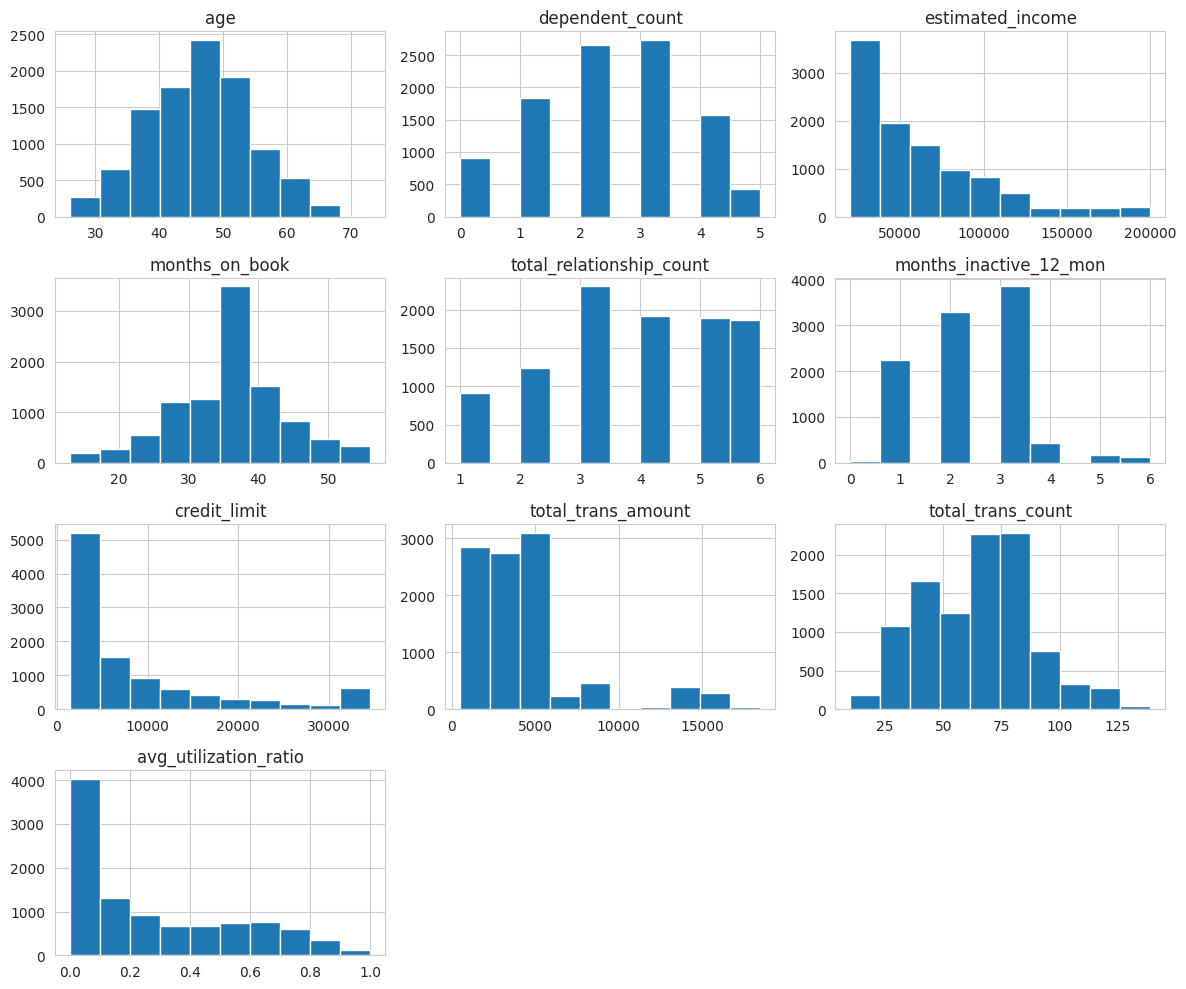

In [43]:
# Histograms to visualize distributions of all numeric features

fig, ax = plt.subplots(figsize=(12, 10))  # Set figure size
customers.drop('customer_id', axis=1).hist(ax=ax)  # Plot histograms, exclude ID

plt.tight_layout()  # Adjust spacing
plt.show()  # Display plots

We have a couple of feature closer to normal distribution, but most of them are skewed. This affects cluster quality and interpretation, making feature preprocessing crucial before applying K-means.

# Feature Engineering

We're now dealing with the 3 categorical variables.

The `gender` column is the easiest one. We'll use a lambda function to replace the values with ones and zeros.

We'll also be able to transform the `education_level` column to numeric. We'll use the `replace()` method to perform this task. This method will assign a value to each level of education:

* `Uneducated - 0`
* `High School - 1`
* `College - 2`
* `Graduate - 3`
* `Post-Graduate - 4`
* `Doctorate - 5`


In [44]:
# Encode gender for K-means clustering: convert categorical 'gender' to binary (M=1, F=0)

customers_modif = customers.copy()
customers_modif['gender'] = customers['gender'].apply(lambda x: 1 if x == 'M' else 0)
customers_modif.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [45]:
customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College':2,
                                    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate':5}, inplace=True)
customers_modif['education_level'].head()

<ipython-input-45-d0f564a7394c>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College':2,


,education_level
0,1
1,3
2,3
3,1
4,0


In [46]:
# One-hot encode categorical 'marital_status':Create dummy variables (n-1 columns to avoid multicollinearity)

dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)
customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)  # Verify new dimensions
customers_modif.head()        # Display transformed data

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False


# Scaling the Data

We'll use scikit-learn's StandardScaler() to standardize the dataset. Standardization is crucial for K-means clustering because the algorithm uses Euclidean distance calculations. Features with larger scales would disproportionately influence clustering decisions. StandardScaler transforms all features to have mean=0 and standard deviation=1, ensuring each feature contributes equally to distance calculations regardless of their original units or ranges. Without standardization, a feature like income (measured in thousands) would overwhelm the influence of age (measured in years) in determining cluster assignments.

In [47]:
# Data for K-means:

X = customers_modif.drop('customer_id', axis=1)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled[:5]  # Display first 5 rows

array([[-0.16540558,  1.05995565,  0.50336813, -0.75221102,  0.1758098 ,
         0.38462088,  0.76394261, -1.32713603,  0.4466219 , -0.95970657,
        -0.97389518, -0.77588223,  1.07733799, -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867,  0.66278684, -0.96716585,
         1.01071482,  1.40730617, -1.32713603, -0.04136665, -0.91643261,
        -1.35734038, -0.61627565, -0.92821381,  1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813,  0.66278684,  0.78539682,
         0.00896451,  0.12057905, -1.32713603, -0.5736978 , -0.74098169,
        -1.91120566, -0.99715499,  1.07733799, -0.79850685, -0.28260887],
       [-0.78912553, -0.9434357 ,  1.2732834 , -0.75221102, -0.63697289,
        -0.24147306, -0.52278451,  1.64147829, -0.58525108, -0.95175829,
        -1.91120566,  1.75968594, -0.92821381, -0.79850685,  3.53845931],
       [-0.78912553,  1.05995565,  0.50336813, -1.45970995,  0.07421197,
        -1.86931731,  0.76394261, -1.32713603, 

# Choosing K

It's time to decide on the number of clusters. We'll run the k-means algorithm considering a range from 1 to 10 possible Ks and store the results. Then, we'll plot the elbow curve that will help us find a final K.

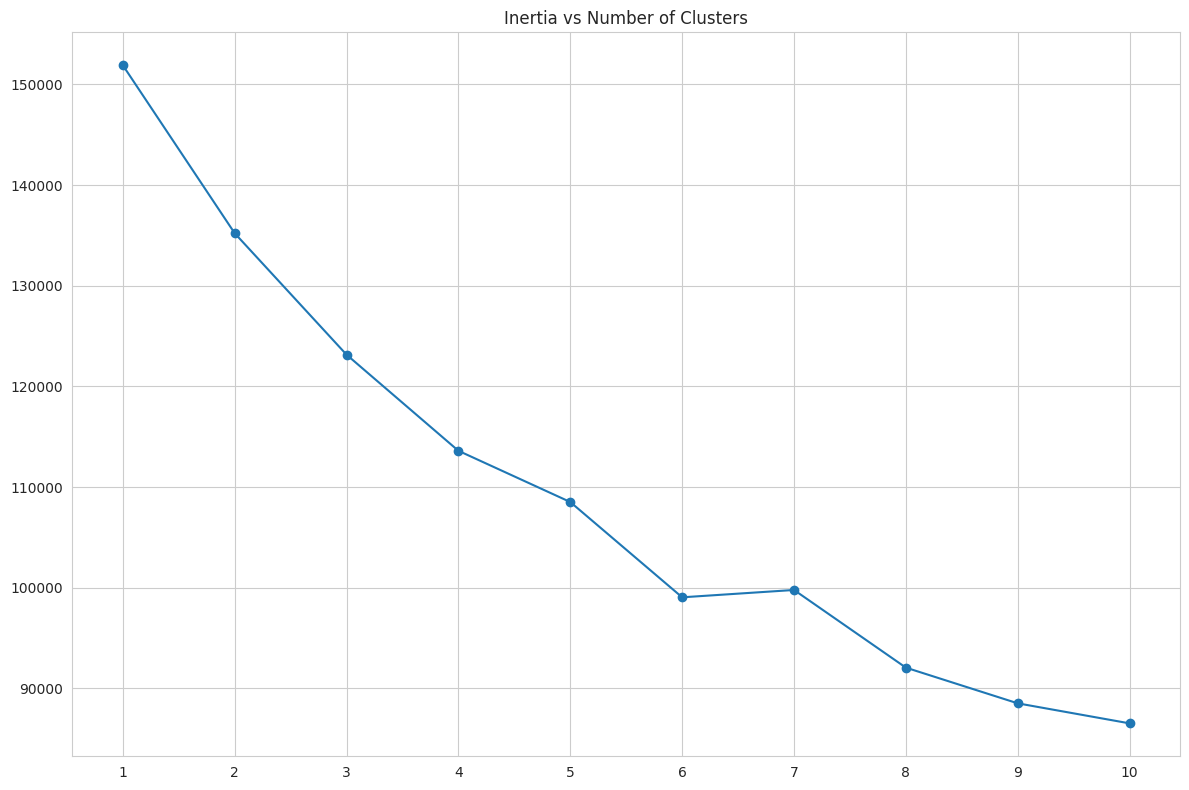

In [48]:
# Elbow method for optimal number of clusters (K-means with k=1 to 10 clusters)

X = pd.DataFrame(X_scaled)
inertias = []

# Calculate inertia for different k values
for k in range(1, 11):
   model = KMeans(n_clusters=k)
   y = model.fit_predict(X)
   inertias.append(model.inertia_)

# Plot elbow curve
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')
plt.tight_layout()
plt.show()

It looks like the rate of decreasing of the inertia slows down between 5 and 7 clusters. We'll use 6 clusters to move on.


In [49]:
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)

y

array([2, 0, 2, ..., 5, 3, 5], dtype=int32)

# Analyzing Results

Now, let's create a `CLUSTER` column in our original dataset so we can better understand the characteristics of each one.

In [50]:
# Assign cluster labels to original dataframe

customers['CLUSTER'] = y + 1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,3
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,1
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,3
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,4
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,1
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,2
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,6
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,4


In [51]:
customers['CLUSTER'].value_counts()

,count
CLUSTER,
6,2690
2,1958
5,1590
3,1590
1,1551
4,748


We can see that cluster 2 is the largest while cluster 3 is the smallest.

Considering the numeric variable only, we'll check on the average value of each variable per cluster. We just need to group the data and plot a bar chart for each column.

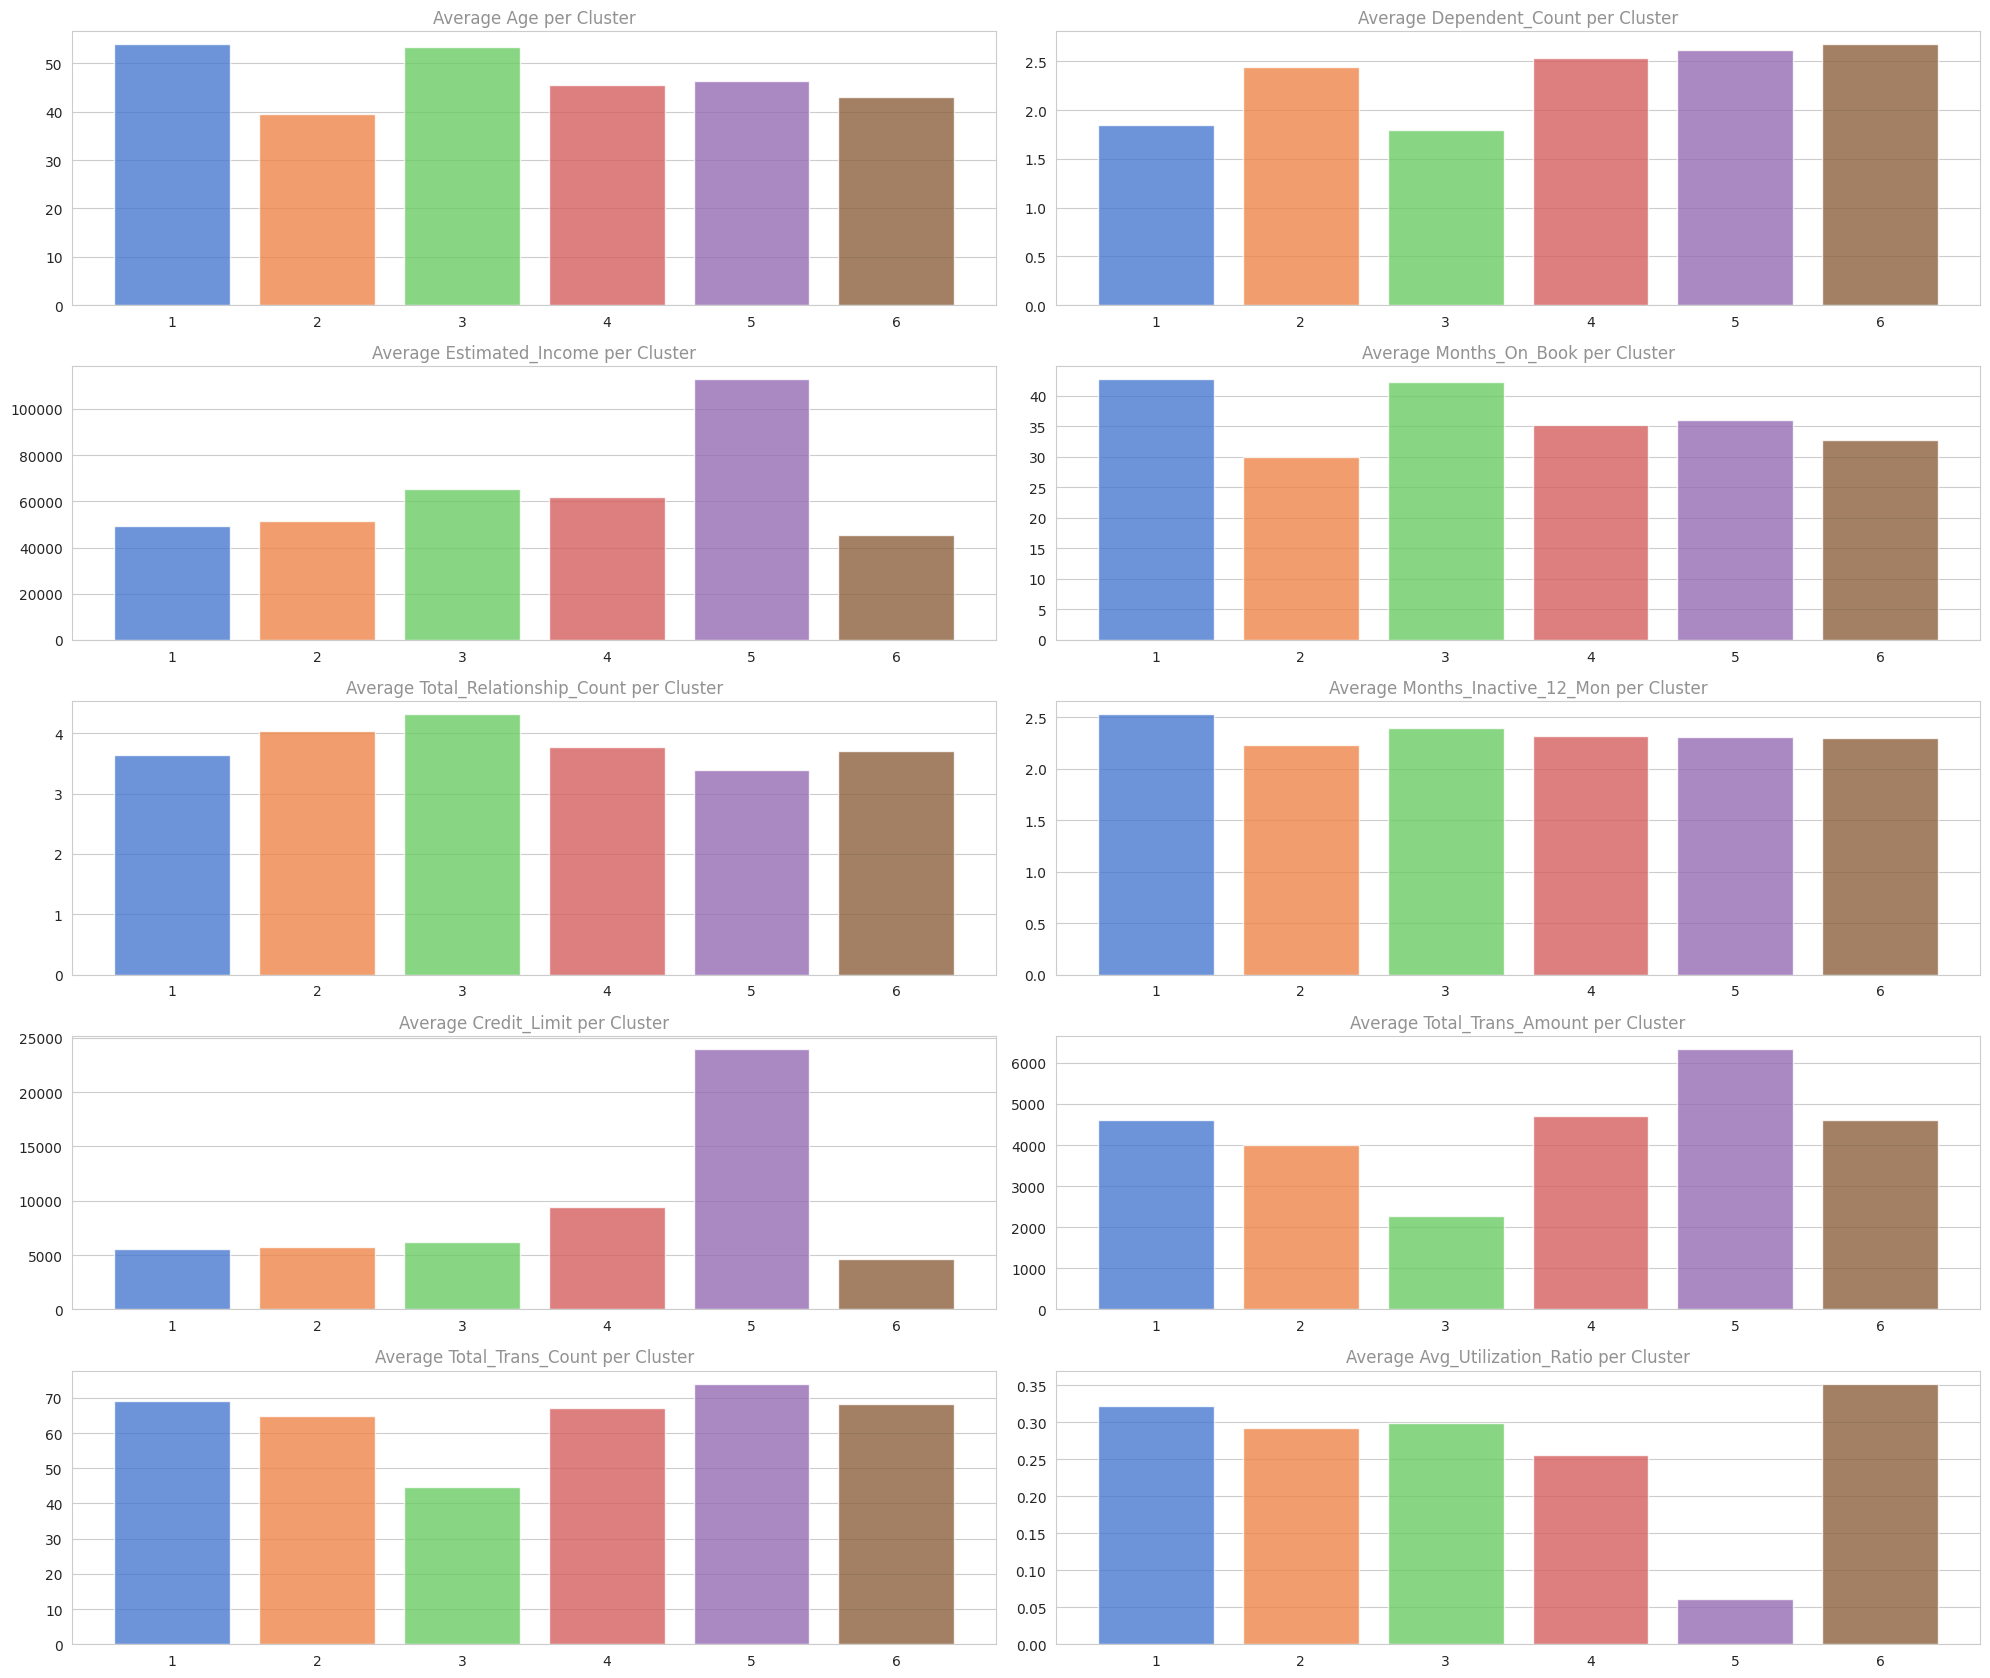

In [76]:
# Visualize average feature values across clusters: Select numeric columns (exclude ID and cluster label)

numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
   df_plot = customers.groupby('CLUSTER')[column].mean()
   ax = fig.add_subplot(6, 2, i+1)
   ax.bar(df_plot.index, df_plot, color=sns.color_palette('muted'), alpha=0.8)
   ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
   ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

For those numerical variables with higher correlations we saw earlier, we can also use a scatter plot to visualize this correlation grouped by clusters and analyze how the clusters change between each area of the chart. We will visualize cluster separation across different feature combinations, helping identify which features best distinguish clusters.

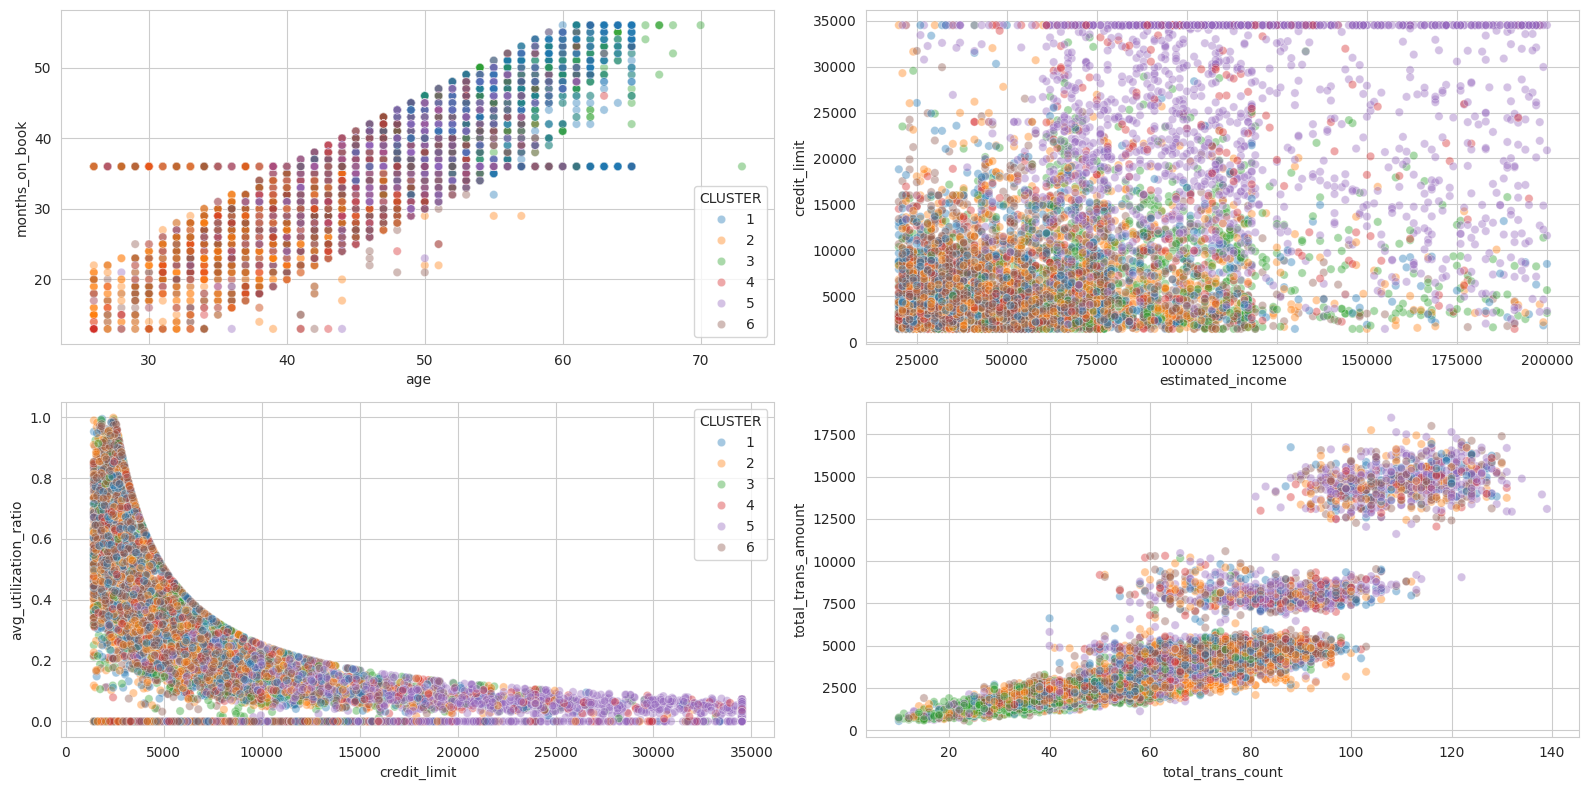

In [78]:
# Create 2x2 grid of scatter plots to visualize cluster patterns:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))


# Age vs Months on Book
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)

# Income vs Credit Limit
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)

# Credit Limit vs Utilization
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)

# Transaction Count vs Amount
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

We can draw some early conclusions considering only the numeric variables.

For instance, Cluster 1 has the highest amount of money transitioned, while Cluster 2 has the lowest credit limit and estimated income and the highest utilization rate. Cluster 4 has the highest credit limit. Older clients are grouped in Cluster 5.

For the categorical columns, we'll plot the percentual distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

<ipython-input-79-cc06f23fcbf7>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
<ipython-input-79-cc06f23fcbf7>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
<ipython-input-79-cc06f23fcbf7>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])


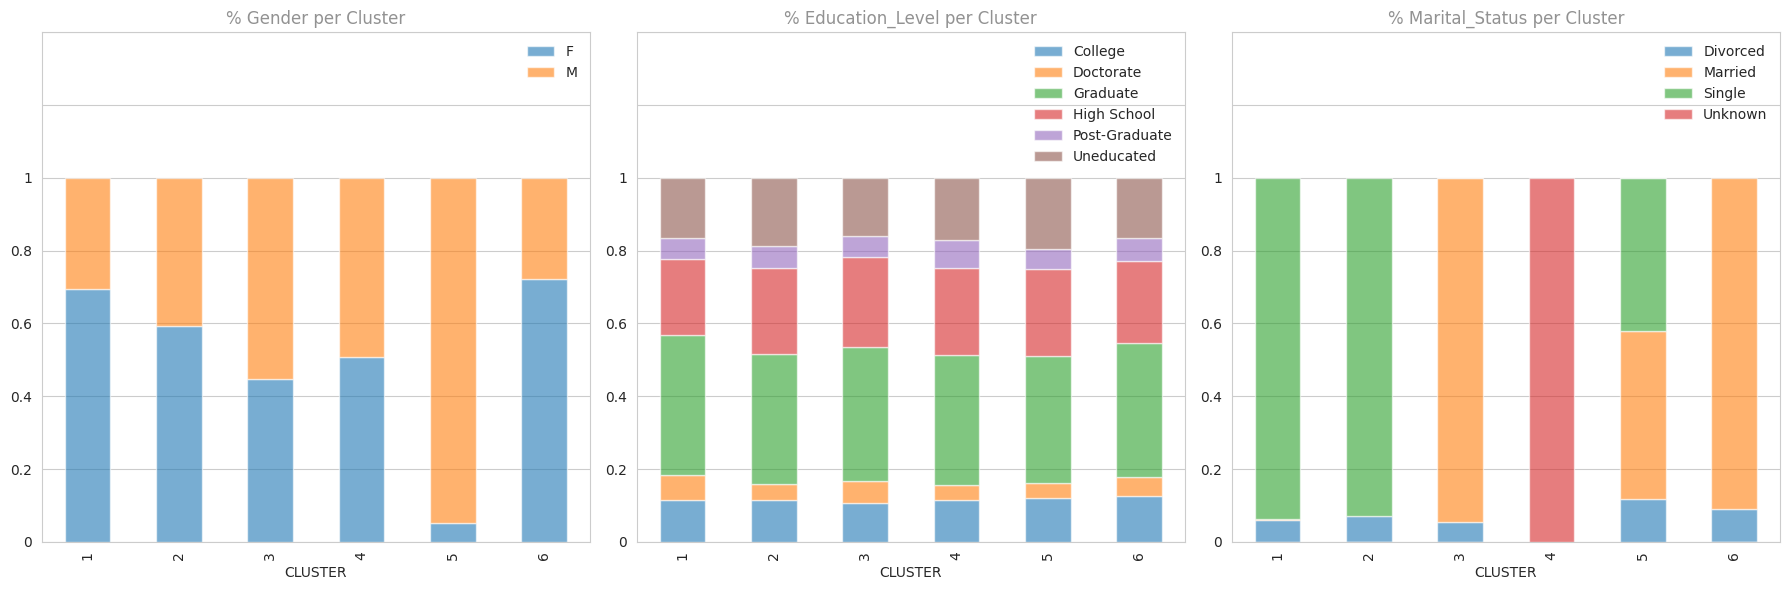

In [79]:
# Visualize categorical feature distributions across clusters

cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
   # Calculate proportions per cluster
   plot_df = pd.crosstab(index=customers['CLUSTER'],
                        columns=customers[col],
                        values=customers[col],
                        aggfunc='size',
                        normalize='index')

   # Create stacked bar plot
   ax = fig.add_subplot(1, 3, i+1)
   plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
   ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

   # Format plot
   ax.set_ylim(0, 1.4)
   ax.legend(frameon=False)
   ax.xaxis.grid(False)
   ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()

Considering the categorical variables, we notice that the education level is well divided between clusters.

In other highlights, Cluster 2 is composed almost entirely of married people, while we don't know the marital status of anybody in Cluster 3. Cluster 4 is almost completely male and Cluster 6 is 100% made of single people.

# Conclusion

As demanded by the company, we now have listed the most important characteristics of each cluster. We could also some suggestions and insights into each one of them.

In the end, we have the list of customers with a cluster assigned to each one.

### Cluster 1

**Characteristics**: Mostly men; high credit limit; high amount transitioned; high number of transactions; low utilization rate.

**Insight**: People with high volume spent on the card, but do not use it on a daily basis. Could be incentivised to spend more.

### Cluster 2

**Characteristics**: Mostly women;  mostly married; low estimated income; low credit limit; low amount transitioned; high utilization rate.

**Insight**: Married people (majority women) with low income and limit but utilize too much of their credit with a few larger purchases

### Cluster 3

**Cluster 3**: Gender well divided; low credit limit, high utilization rate; marital status 100% unknown; smaller cluster.

**Insight**: Men and women with low credit limits but do have high balances.

### Cluster 4

**Cluster 4**: Mostly men, mostly single and married, high estimated income, high credit limit; low amount transitioned; low utilization rate.

**Insight**: People (majority men) with high income and credit limits, but don't use the card. Could be incentivized to use it.

### Cluster 5

**Cluster 5**: Mostly married, high age, low dependent count, long time customers, low credit limit, low amount transitioned, high utilization rate.

**Insight**: Older people and long-time customers. Low credit limit and transactions, but use the card very often. Could receive benefits to spend more money.

### Cluster 6

**Cluster 6**: Mostly women; 100% single people, low estimated income, low credit limit, low amount transitioned, high utilization rate.

**Insight**: Single (mostly women) people that use their card a lot but have low credit limits and income. Could be given a bit more credit limit.

In [29]:
# List of customers and clusters
customers[['customer_id', 'CLUSTER']]

,customer_id,CLUSTER
0,768805383,3
1,818770008,1
2,713982108,3
3,769911858,4
4,709106358,6
...,...,...
10122,772366833,1
10123,710638233,2
10124,716506083,6
10125,717406983,4
